In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
trips = pd.read_csv('tripdata_2019-05.csv')

In [3]:
# trips

Заменим невалидные значения в колонках:

кол-во пассажиров установим в 1;

// RatecodeId в 5(договорная оплата);

// store_and_fwd_flag в N(передача данных осуществлялась из памяти средства передвижения, т.е. прямое подключение к серверу отсутствовало);

// payment_type в 5(Unknown payment type);

In [4]:
trips.passenger_count = trips.passenger_count.fillna(1)

Посмотрим на количество колонок, в которых встречаются данные со значением Nan.

In [5]:
for el in trips.columns:
    print(el, trips[el].isna().sum())

VendorID 0
tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 0
trip_distance 0
RatecodeID 0
store_and_fwd_flag 0
PULocationID 0
DOLocationID 0
payment_type 0
fare_amount 0
extra 0
mta_tax 0
tip_amount 0
tolls_amount 0
improvement_surcharge 0
total_amount 0
congestion_surcharge 0


In [6]:
# trips

Преобразуем формат ячеек с временем для удобства.

In [7]:
trips['tpep_pickup_datetime'] = pd.to_datetime(trips.tpep_pickup_datetime)
trips['tpep_dropoff_datetime'] = pd.to_datetime(trips.tpep_dropoff_datetime)

Введём новые колонки: 

1. с датой начала поездки; 

2. с часом начала и конца;

3. с днём недели начала поездки; 

4. с временем продолжительности поездки(день конца поездки игнорируем, т.к. почти все поездки будут в промежутке одного дня);

5. временем поездки в секундах;

6. средней скоростью в м/с.

In [8]:
trips['trip_pickup_day'] = trips.tpep_pickup_datetime.dt.day
trips['week_day'] = trips.tpep_pickup_datetime.dt.dayofweek
trips['trip_pickup_hour'] = trips.tpep_pickup_datetime.dt.hour
trips['trip_dropoff_hour'] = trips.tpep_dropoff_datetime.dt.hour
trips['trip_duration'] = trips.tpep_dropoff_datetime - trips.tpep_pickup_datetime
trips['trip_duration_secs'] = trips.trip_duration.dt.seconds
trips['average_velocity'] = (trips['trip_distance'] * 1609.34) / trips['trip_duration_secs']

In [9]:
# trips

Посмотрим, есть ли в данных нереальные случаи(например за короткое слишком большое ограничение).

Установим ограничение для средней скорости в 162 км/ч(45 м/с) сверху и 2(м/с) снизу, а также удалим строки, в которых преодолено нулевое расстояние за ненулевое время, при этом получена некоторая сумма за поездку.

Была мысль также выпилить строки с отрицательной оплатой, но почему-то есть вариант, что это поездки за бонусные баллы(ну например). Если надо, выпилим.

In [10]:
trips = trips[trips.average_velocity <= 45]
trips = trips[trips.average_velocity > 2]
trips = trips[trips.tpep_pickup_datetime <= trips.tpep_dropoff_datetime]
trips = trips.drop(trips[(trips.trip_distance == 0) & (trips.total_amount > 0) & (trips.trip_duration_secs > 0)].index)

In [11]:
trips

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
1,1,2019-05-01 00:35:54,2019-05-01 00:37:27,1,1.50,1,N,145,145,2,...,0.3,4.30,0.0,1,2,0,0,00:01:33,93,25.957097
3,1,2019-05-01 00:44:57,2019-05-01 00:50:11,1,0.70,1,N,161,161,2,...,0.3,8.80,2.5,1,2,0,0,00:05:14,314,3.587701
4,1,2019-05-01 00:59:48,2019-05-01 01:10:22,1,2.00,1,N,163,141,1,...,0.3,15.30,2.5,1,2,0,1,00:10:34,634,5.076782
7,1,2019-05-01 00:23:20,2019-05-01 00:32:57,1,2.50,1,N,260,56,2,...,0.3,11.30,0.0,1,2,0,0,00:09:37,577,6.972877
8,1,2019-05-01 00:35:54,2019-05-01 00:47:49,1,2.80,1,N,56,226,2,...,0.3,12.80,0.0,1,2,0,0,00:11:55,715,6.302310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565253,2,2019-05-31 23:40:41,2019-05-31 23:45:16,1,0.44,1,N,163,142,2,...,0.3,7.80,2.5,31,4,23,23,00:04:35,275,2.574944
7565254,2,2019-05-31 23:47:35,2019-05-31 23:57:15,1,1.39,1,N,43,229,1,...,0.3,14.16,2.5,31,4,23,23,00:09:40,580,3.856867
7565256,2,2019-05-31 23:22:08,2019-05-31 23:58:35,3,15.69,1,N,231,153,1,...,0.3,62.88,2.5,31,4,23,23,00:36:27,2187,11.545745
7565257,2,2019-05-31 23:10:12,2019-05-31 23:17:56,1,1.42,1,N,262,237,1,...,0.3,14.12,2.5,31,4,23,23,00:07:44,464,4.925135


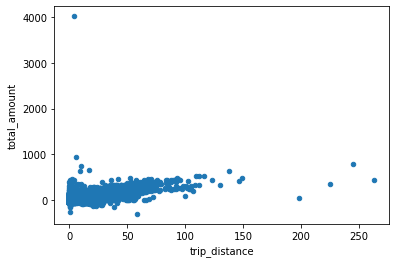

In [12]:
trips.plot.scatter(x='trip_distance', y='total_amount')

Построим гистограммы по дню поездки, где понедельник = 0, воскресенье = 6.

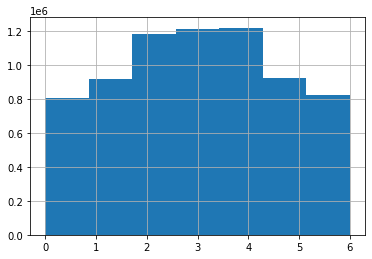

In [13]:
trips.week_day.hist(bins=7)

Посмотрим на распределение по каждому дню недели.

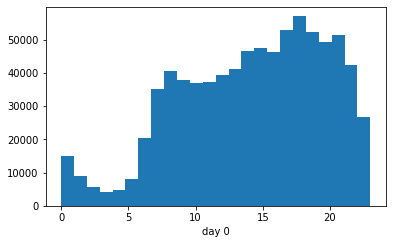

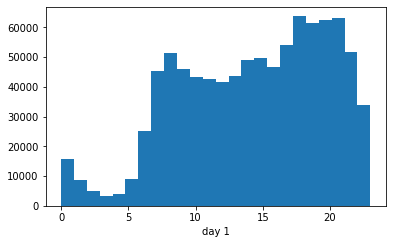

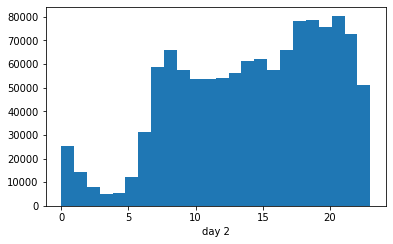

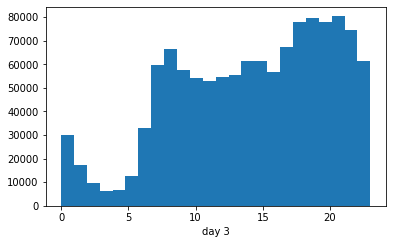

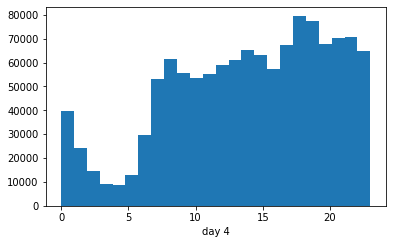

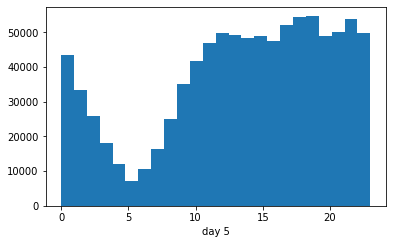

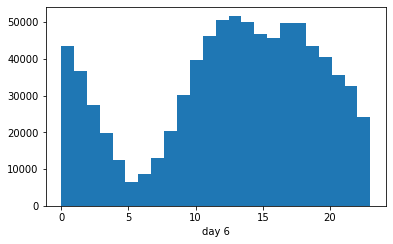

In [14]:
for i in range(7):
    plt.figure(figsize=(50,30))
    plt.subplot(7, 7, i + 1)
    plt.xlabel('day ' + str(i))
    plt.hist(trips[trips.week_day == i].trip_pickup_hour, bins=24)

По дате начала поездки.

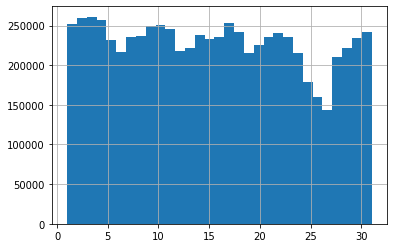

In [15]:
trips.trip_pickup_day.hist(bins=31)

По часу начала и конца.

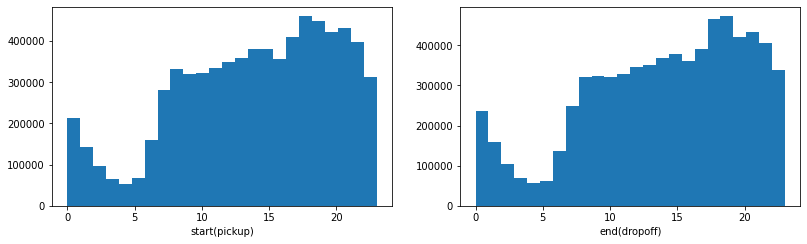

In [16]:
plt.figure(figsize=(50, 30))
plt.subplot(7, 7, 1)
plt.xlabel('start(pickup)')
arr_val1 = plt.hist(trips.trip_pickup_hour, bins=24)
plt.subplot(7, 7, 2)
plt.xlabel('end(dropoff)')
arr_val2 = plt.hist(trips.trip_dropoff_hour, bins=24)